In [1]:
import os
import itertools, collections
import numpy, scipy, pandas
import scipy.signal
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn
from imp import reload

from pgtools import toolbox, myplots
import pygbrowse
import empdist
from empdist import EmpiricalDistribution
from peas import scoring, arrayfuncs

In [2]:
seaborn.set_style('darkgrid')

In [3]:
reload(empdist)
reload(arrayfuncs)
reload(scoring)

<module 'peas.scoring' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/scoring.py'>

In [4]:
# For vector, where permuted region means are indepdendent
def generate_empirical_distributions_region_means(data,
                                                  max_region_size,
                                                  bins='auto',
                                                  pseudocount=0):
    """
    Given a population sample, return a list of frozen empirical distribution
    objects representing the inferred distributions of the mean value of samples taken from
    that population of sizes [1, :param:`max_region_size`].

    Distributions of sample sizes below :param:`max_empirical_size` will be empirical piecewise
    histograms of size :param:`num_bins` * sample_size.

    Distributions of sample sizes above :param:`max_empirical_size` will be normal approximations.

    Returns a dictionary, keyed by region size, of MyEmpiricalDistribution objects.
    """
    # ToDo: Clean up flow control.
    assert max_region_size >= 1
    empirical_distros_by_region_size = {}

    if len(data.shape) > 1:  # force data to be 1-D
        data = data.flatten()

    data_distro = EmpiricalDistribution.from_data(data, bins=bins, pseudocount=pseudocount)
    new_frequencies = singleton_pdf.frequencies
    pdfs = [singleton_pdf]

    for region_size in range(2, min(max_region_size, max_empirical_size) + 1):
        new_frequencies = scipy.signal.convolve(new_frequencies, singleton_pdf.frequencies, mode='full', method='auto')

        if resample:
            empirical_distros_by_region_size[region_size] = EmpiricalDistribution \
                (resample_array(new_frequencies, new_size=num_bins, support=support), support=support,
                 pseudocount=pseudocount)
        else:
            empirical_distros_by_region_size[region_size] = EmpiricalDistribution(new_frequencies, support=support,
                                                                                  pseudocount=pseudocount)

    if max_region_size > max_empirical_size:
        for region_size in range(max(2, max_empirical_size), max_region_size + 1):
            new_pdf = scipy.stats.norm(loc=data_mean, scale=numpy.sqrt(data_var * region_size) / region_size)
            empirical_distros_by_region_size[region_size] = new_pdf

    return empirical_distros_by_region_size




In [123]:
def predict_distributions_independent_sums(input_empirical_distribution,
                                           max_sample_size):
    """
    Given a population sample, return a list of frozen empirical distribution
    objects representing the inferred distributions of the sum of samples taken from
    that population of sizes [1, :param:`max_sample_size`].

    Returns a dictionary, keyed by region size, of EmpiricalDistribution objects.
    """
    assert max_sample_size >= 1

    empirical_distros_by_region_size = {1: input_empirical_distribution}

    for sample_size in range(2, max_sample_size + 1):
        empirical_distros_by_region_size[sample_size] = empirical_distros_by_region_size[
                                                            sample_size - 1] + input_empirical_distribution

    return empirical_distros_by_region_s

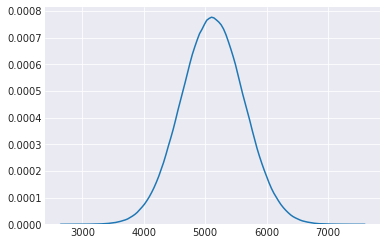

In [96]:
seaborn.kdeplot(X)

In [97]:
%%time
numpy.random.seed(1)
X = scipy.stats.norm(10).rvs(n)
real_sum_distributions = {1:X_distro}
running_sum = X
for sample_size in range(2, 11):
    running_sum += scipy.stats.norm(10).rvs(n)
    real_sum_distributions[sample_size] = EmpiricalDistribution.from_data(running_sum)

CPU times: user 2min, sys: 3.66 s, total: 2min 4s
Wall time: 56.2 s


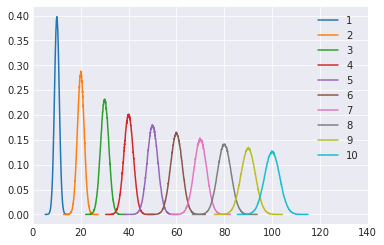

In [98]:
for sample_size in range(1,11):
    plt.plot(real_sum_distributions[sample_size].densities, label=sample_size)
plt.xlim(0,140)
plt.legend()

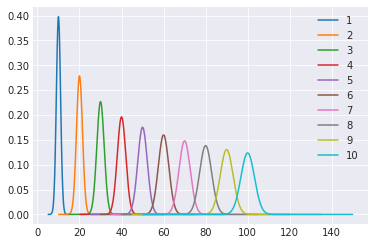

In [88]:
predicted_sum_distributions = peas.distributions.predict_distributions_indepdendent_sums(X_distro, 10)
for region_size, distro in predicted_sum_distributions.items():
    plt.plot(distro.densities, label=region_size)
plt.legend()

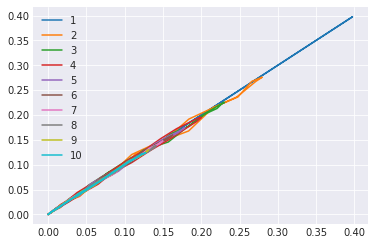

In [102]:
for sample_size in range(1,11):
    xs = numpy.linspace(*real_sum_distributions[sample_size].support)
    plt.plot(real_sum_distributions[sample_size].pdf(xs), predicted_sum_distributions[sample_size].pdf(xs), label=sample_size)
plt.legend()

### Means

In [126]:
reload(empdist)
from empdist import EmpiricalDistribution

In [195]:
%%time
numpy.random.seed(1)
X = scipy.stats.norm(10).rvs(n)
X_distro = EmpiricalDistribution.from_data(X)
real_sums = {1:X}
for sample_size in range(2, 11):
    real_sums[sample_size] = real_sums[sample_size-1] + scipy.stats.norm(10).rvs(n)    

CPU times: user 16.9 s, sys: 284 ms, total: 17.1 s
Wall time: 6.74 s


In [201]:
%%time
real_sum_distributions = {1:X_distro}
for sample_size in range(2, 11):
    real_sum_distributions[sample_size] = EmpiricalDistribution.from_data(real_sums[sample_size])

CPU times: user 1min 48s, sys: 2.46 s, total: 1min 50s
Wall time: 55.4 s


In [196]:
%%time
real_means = {sample_size:real_sums[sample_size] / sample_size for sample_size in real_sums}
real_mean_distributions = {sample_size:EmpiricalDistribution.from_data(real_means[sample_size]) for sample_size in real_means}

CPU times: user 1min 57s, sys: 2.67 s, total: 1min 59s
Wall time: 1min


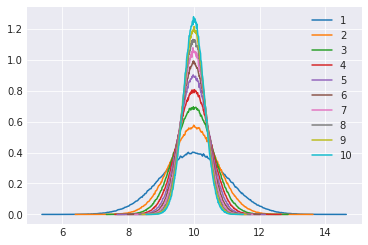

In [197]:
for sample_size in range(1,11):
    plt.plot(real_mean_distributions[sample_size].densities, label=sample_size)
# plt.xlim(0,140)
plt.legend()

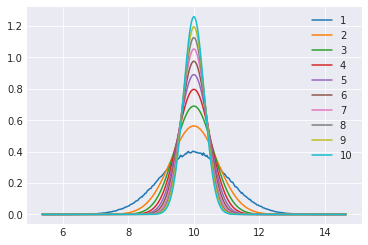

In [198]:
predicted_mean_distributions = peas.distributions.predict_distributions_indepdendent_means(X_distro, 10)
for region_size, distro in predicted_mean_distributions.items():
    plt.plot(distro.densities, label=region_size)
plt.legend()

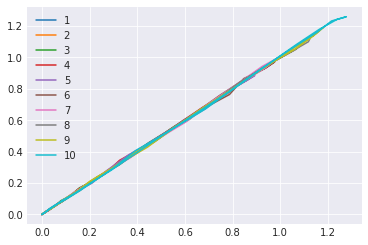

In [202]:
for sample_size in range(1,11):
    xs = numpy.linspace(*real_mean_distributions[sample_size].support)
    plt.plot(real_mean_distributions[sample_size].pdf(xs), predicted_mean_distributions[sample_size].pdf(xs), label=sample_size)
plt.legend()

In [220]:
reload(empdist.helper_funcs)

<module 'empdist.helper_funcs' from '/gpfs/data01/glasslab/home/dskola/workspace/empirical-distribution/empdist/helper_funcs.py'>

In [222]:
def predict_distributions_independent_mins(input_empirical_distribution,
                                           max_sample_size):
    """
    Given a population sample, return a list of frozen empirical distribution
    objects representing the inferred distributions of the sum of samples taken from
    that population of sizes [1, :param:`max_sample_size`].

    Returns a dictionary, keyed by region size, of EmpiricalDistribution objects.
    """
    assert max_sample_size >= 1

    empirical_distros_by_region_size = {1: input_empirical_distribution}

    for sample_size in range(2, max_sample_size + 1):
        empirical_distros_by_region_size[sample_size] = empdist.helper_funcs.distribution_minimum(empirical_distros_by_region_size[
                                                            sample_size - 1], input_empirical_distribution)

    return empirical_distros_by_region_size

In [231]:
%%time
numpy.random.seed(1)
X = scipy.stats.norm(10).rvs(n)
X_distro = EmpiricalDistribution.from_data(X)

real_mins = {1:X}
for sample_size in range(2, 11):
    real_mins[sample_size] = numpy.minimum(real_mins[sample_size-1], scipy.stats.norm(10).rvs(n))

CPU times: user 14.9 s, sys: 204 ms, total: 15.1 s
Wall time: 6.92 s


In [223]:
%%time
real_min_distributions = {sample_size:EmpiricalDistribution.from_data(real_mins[sample_size]) for sample_size in real_mins}

CPU times: user 1min 54s, sys: 3.2 s, total: 1min 57s
Wall time: 57.4 s


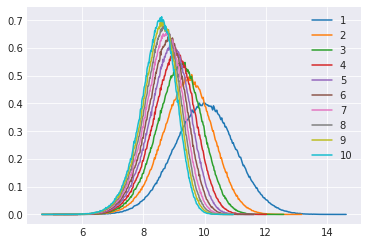

In [227]:
for sample_size in range(1,11):
    plt.plot(real_min_distributions[sample_size].densities, label=sample_size)
plt.legend()

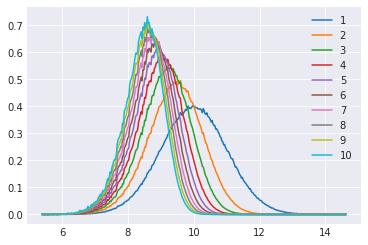

In [228]:
predicted_min_distributions = predict_distributions_independent_mins(X_distro, 10)
for region_size, distro in predicted_min_distributions.items():
    plt.plot(distro.densities, label=region_size)
plt.legend()

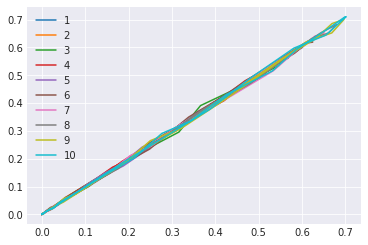

In [229]:
for sample_size in range(1,11):
    xs = numpy.linspace(*real_min_distributions[sample_size].support)
    plt.plot(real_min_distributions[sample_size].pdf(xs), predicted_min_distributions[sample_size].pdf(xs), label=sample_size)
plt.legend()

### Max

In [235]:
def predict_distributions_independent_maxes(input_empirical_distribution,
                                           max_sample_size):
    """
    Given a population sample, return a list of frozen empirical distribution
    objects representing the inferred distributions of the sum of samples taken from
    that population of sizes [1, :param:`max_sample_size`].

    Returns a dictionary, keyed by region size, of EmpiricalDistribution objects.
    """
    assert max_sample_size >= 1

    empirical_distros_by_region_size = {1: input_empirical_distribution}

    for sample_size in range(2, max_sample_size + 1):
        empirical_distros_by_region_size[sample_size] = empdist.helper_funcs.distribution_maximum(empirical_distros_by_region_size[
                                                            sample_size - 1], input_empirical_distribution)

    return empirical_distros_by_region_size

In [232]:
%%time
numpy.random.seed(1)
X = scipy.stats.norm(10).rvs(n)
X_distro = EmpiricalDistribution.from_data(X)

real_maxes = {1:X}
for sample_size in range(2, 11):
    real_maxes[sample_size] = numpy.maximum(real_maxes[sample_size-1], scipy.stats.norm(10).rvs(n))

CPU times: user 14.8 s, sys: 459 ms, total: 15.2 s
Wall time: 6.85 s


In [233]:
%%time
real_max_distributions = {sample_size:EmpiricalDistribution.from_data(real_maxes[sample_size]) for sample_size in real_maxes}

CPU times: user 2min, sys: 2.4 s, total: 2min 2s
Wall time: 1min 2s


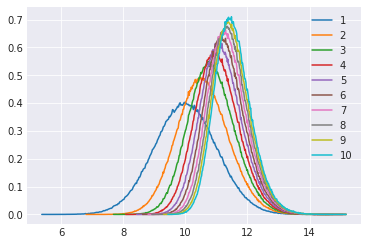

In [234]:
for sample_size in range(1,11):
    plt.plot(real_max_distributions[sample_size].densities, label=sample_size)
plt.legend()

In [237]:
reload(empdist.helper_funcs)

<module 'empdist.helper_funcs' from '/gpfs/data01/glasslab/home/dskola/workspace/empirical-distribution/empdist/helper_funcs.py'>

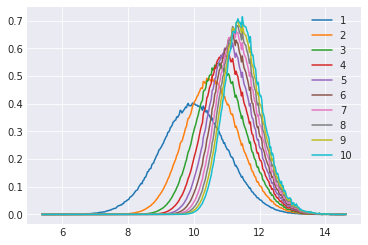

In [263]:
predicted_max_distributions = predict_distributions_independent_maxes(X_distro, 10)
for region_size, distro in predicted_max_distributions.items():
    plt.plot(distro.densities, label=region_size)
    
plt.legend()

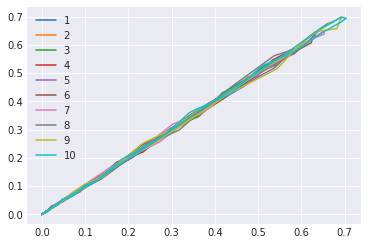

In [264]:
for sample_size in range(1,11):
    xs = numpy.linspace(*real_max_distributions[sample_size].support)
    plt.plot(real_max_distributions[sample_size].pdf(xs), predicted_max_distributions[sample_size].pdf(xs), label=sample_size)
plt.legend()